In [1]:
%matplotlib inline

# 讓機器認識中文字

###測試於tensorflow 1.10  keras 2.2.2

![md_images](../Images/hanzi.jpg?raw=true)

## 從錯誤率90幾%到正確率90幾%之路 

In [2]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import random
import glob
from PIL import Image

import tensorflow as tf
from keras.models import *
from keras.layers import * 
from keras.losses import * 
from keras.callbacks import *
from keras.preprocessing import image
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.applications import * 
from keras.applications.imagenet_utils import *
from keras.utils.np_utils import to_categorical
from keras.optimizers import  Adam
from keras.preprocessing.image import *

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
config.gpu_options.visible_device_list = "0"
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.40
set_session(tf.Session(config=config))

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

Using TensorFlow backend.


In [3]:
imgs=glob.glob('../Data/ex02_train/*/*.jpg')
print('圖片數量:{0}'.format(len(imgs)))
print(imgs[:3])
print('')

#list(sorted(set()))去重複排序後產生清單=>產生對應onehot編碼
words=list(sorted(set([im.split('\\')[1] for im in imgs])))
print('中文字數量:{0}'.format(len(words)))
print(''.join(words))

圖片數量:40000
['../Data/ex02_train\\且\\000dcbf63744a53232b396f008a89c5f62344c80.jpg', '../Data/ex02_train\\且\\00207070a7650d5aca1b47df9710f97467b85602.jpg', '../Data/ex02_train\\且\\00456a8cffb776c66997dd0256da314f93fb7283.jpg']

中文字數量:100
且世东九亭今从令作使侯元光利印去受右司合名周命和唯堂士多夜奉女好始字孝守宗官定宜室家寒左常建徐御必思意我敬新易春更朝李来林正武氏永流海深清游父物玉用申白皇益福秋立章老臣良莫虎衣西起足身通遂重陵雨高黄鼎


In [4]:
word2idx={}
idx2word={}
for i, w in enumerate(words):
    word2idx[w]=i
    idx2word[i]=w
print(word2idx) 

{'西': 88, '衣': 87, '新': 53, '益': 77, '从': 6, '利': 13, '东': 2, '敬': 52, '定': 38, '令': 7, '和': 23, '父': 70, '九': 3, '海': 66, '永': 64, '守': 35, '高': 97, '物': 71, '世': 1, '右': 17, '光': 12, '李': 58, '黄': 98, '易': 54, '且': 0, '家': 41, '遂': 93, '雨': 96, '玉': 72, '作': 8, '莫': 85, '意': 50, '侯': 10, '陵': 95, '鼎': 99, '元': 11, '命': 22, '老': 82, '受': 16, '士': 26, '身': 91, '申': 74, '清': 68, '字': 33, '堂': 25, '左': 43, '更': 56, '御': 47, '官': 37, '我': 51, '宜': 39, '名': 20, '章': 81, '足': 90, '思': 49, '今': 5, '女': 30, '林': 60, '流': 65, '常': 44, '好': 31, '徐': 46, '良': 84, '用': 73, '立': 80, '合': 19, '正': 61, '印': 14, '重': 94, '福': 78, '必': 48, '皇': 76, '司': 18, '朝': 57, '春': 55, '室': 40, '虎': 86, '宗': 36, '去': 15, '起': 89, '夜': 28, '深': 67, '始': 32, '白': 75, '建': 45, '秋': 79, '氏': 63, '多': 27, '游': 69, '武': 62, '臣': 83, '周': 21, '亭': 4, '通': 92, '寒': 42, '来': 59, '唯': 24, '使': 9, '奉': 29, '孝': 34}


亭


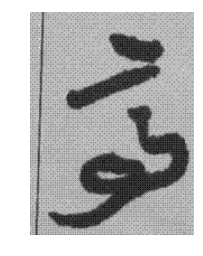

In [5]:
imgpath=random.choice(imgs)
img = Image.open(imgpath)
print(imgpath.split('\\')[1])
plt.axis('off')
plt.imshow(img,cmap='gray')


In [6]:
train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
            '../Data/ex02_train/',
            classes=words,
            color_mode='grayscale',
            target_size=(64, 64),
            batch_size=16,
            class_mode='categorical')
    

Found 40000 images belonging to 100 classes.


In [7]:
def resnet_basic(x,nb_filter,kernel_size=3):
    out = Conv2D(nb_filter,(kernel_size,kernel_size), padding="same")(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

    out = Conv2D(nb_filter,(kernel_size,kernel_size), padding="same")(out)
    out = BatchNormalization()(out)

    out = add([out,x])
    out = Activation('relu')(out)
    return out

def resnet_basic_inc(x,nb_filter,kernel_size=3):
    out = Conv2D(nb_filter,(kernel_size,kernel_size),strides=2, padding="same")(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

    out = Conv2D(nb_filter,(kernel_size,kernel_size), padding="same")(out)
    out = BatchNormalization()(out)

    x = Conv2D(nb_filter,(1,1),strides=2, padding="same")(x)
    x = BatchNormalization()(x)

    out = add([out,x])
    out = Activation('relu')(out)
    return out



inp = Input(shape=(64,64,1))
out = Conv2D(16,(3,3))(inp)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = resnet_basic(out,16)
out = resnet_basic(out,16)
out = resnet_basic(out,16)
out = resnet_basic(out,16)
out = resnet_basic(out,16)
out = resnet_basic_inc(out,64)
out = resnet_basic(out,64)
out = resnet_basic(out,64)
out = resnet_basic(out,64)
out = resnet_basic(out,64)
out = resnet_basic(out,64)
out = resnet_basic_inc(out,128)
out = resnet_basic(out,128)
out = resnet_basic(out,128)
out = resnet_basic(out,128)
out = Conv2D(100,(1,1))(out)
out = GlobalMaxPooling2D()(out)
model = Model(inp,out)

In [8]:
def plot_history(history):
    plt.plot(history['acc1'])
    plt.plot(history['acc2'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('mbs')
    plt.legend(['resnet01', 'resnet02'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss1'])
    plt.plot(history['loss2'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('mbs')
    plt.legend(['resnet01', 'resnet02'], loc='upper left')
    plt.show()

In [9]:

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=10e-4, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=30)
#最後將模型存檔
json_string = model.to_json()
open('Models/hanzi_resnet_keras.json', 'w').write(json_string)
model.save_weights('Models/hanzi_resnet_keras.hdf5')

Epoch 1/30
100/100 [==============================] - 18s 176ms/step - loss: 6.0689 - acc: 0.0144
Epoch 2/30
100/100 [==============================] - 9s 89ms/step - loss: 9.3058 - acc: 0.0138
Epoch 3/30
100/100 [==============================] - 9s 89ms/step - loss: 9.0236 - acc: 0.0106
Epoch 4/30
100/100 [==============================] - 9s 90ms/step - loss: 9.0751 - acc: 0.0119
Epoch 5/30
100/100 [==============================] - 9s 91ms/step - loss: 8.5459 - acc: 0.0094
Epoch 6/30
100/100 [==============================] - 9s 92ms/step - loss: 8.3600 - acc: 0.0125
Epoch 7/30
100/100 [==============================] - 9s 92ms/step - loss: 8.1289 - acc: 0.0106
Epoch 8/30
100/100 [==============================] - 9s 90ms/step - loss: 8.4127 - acc: 0.0100
Epoch 9/30
100/100 [==============================] - 9s 90ms/step - loss: 8.0787 - acc: 0.0125
Epoch 10/30
100/100 [==============================] - 9s 90ms/step - loss: 8.6091 - acc: 0.0081
Epoch 11/30
100/100 [================